In [1]:
#!pip install nibabel tqdm scikit-image

In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
#GPU 확인
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11358884206603800286
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914163099
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8937676977855892369
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
def preprocess(img_name):
    img_path = path

In [4]:
def img_resize(img) :
    image = resize(image, output_shape=(256, 256, 1), preserve_range=True)
    
    return img

In [5]:
#데이터 셋 가져오기
def get_mask_data():

    x_train_path = "dataset/Image_Segmentation/x_train.npy"
    x_val_path = "dataset/Image_Segmentation/x_val.npy" 
    y_train_path = "dataset/Image_Segmentation/y_train.npy"
    y_val_path = "dataset/Image_Segmentation/y_val.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [6]:
# CNN 인 VGG16 U-net
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(1, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [7]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    
    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')
    

    preds = model.predict(x_val)
    fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
    temp = np.empty((256, 256, 1), dtype=np.float32)

    for i in range(40):
        ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
        ax[i, 0].title.set_text(str(i))
        ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
        ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        temp = x_val[i]
        pred_sum = preds[i][preds[i] > 0]
        pred_mean = np.mean(pred_sum)
        if(np.min(temp) >= 0) :
            temp[preds[i] < pred_mean] = 0
        else :
            temp[preds[i] < pred_mean] = -2048
        ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(2675, 256, 256, 1) (2675, 256, 256, 1)
(298, 256, 256, 1) (298, 256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][0]                   
________________

Epoch 1/30
168/168 [==============================] - 123s 603ms/step - loss: 0.4480 - acc: 0.8280 - mean_io_u: 0.5000 - val_loss: 0.1676 - val_acc: 0.8674 - val_mean_io_u: 1.0000
Epoch 2/30
168/168 [==============================] - 97s 576ms/step - loss: 0.1088 - acc: 0.8675 - mean_io_u: 1.0000 - val_loss: 0.0297 - val_acc: 0.8674 - val_mean_io_u: 1.0000
Epoch 3/30
168/168 [==============================] - 106s 630ms/step - loss: 0.0166 - acc: 0.8675 - mean_io_u: 1.0000 - val_loss: 0.0110 - val_acc: 0.8674 - val_mean_io_u: 1.0000
Epoch 4/30
168/168 [==============================] - 108s 642ms/step - loss: 0.0067 - acc: 0.8675 - mean_io_u: 1.0000 - val_loss: 0.0069 - val_acc: 0.8674 - val_mean_io_u: 1.0000
Epoch 5/30
168/168 [==============================] - 104s 620ms/step - loss: 0.0063 - acc: 0.8675 - mean_io_u: 1.0000 - val_loss: 0.0066 - val_acc: 0.8674 - val_mean_io_u: 1.0000
Epoch 6/30
168/168 [==============================] - 110s 654ms/step - loss: 0.0062 - acc: 0.8675 - 

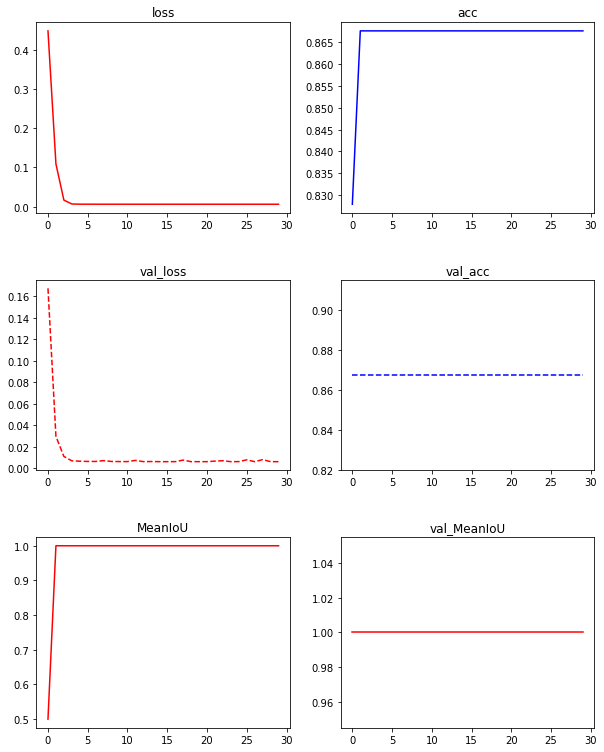

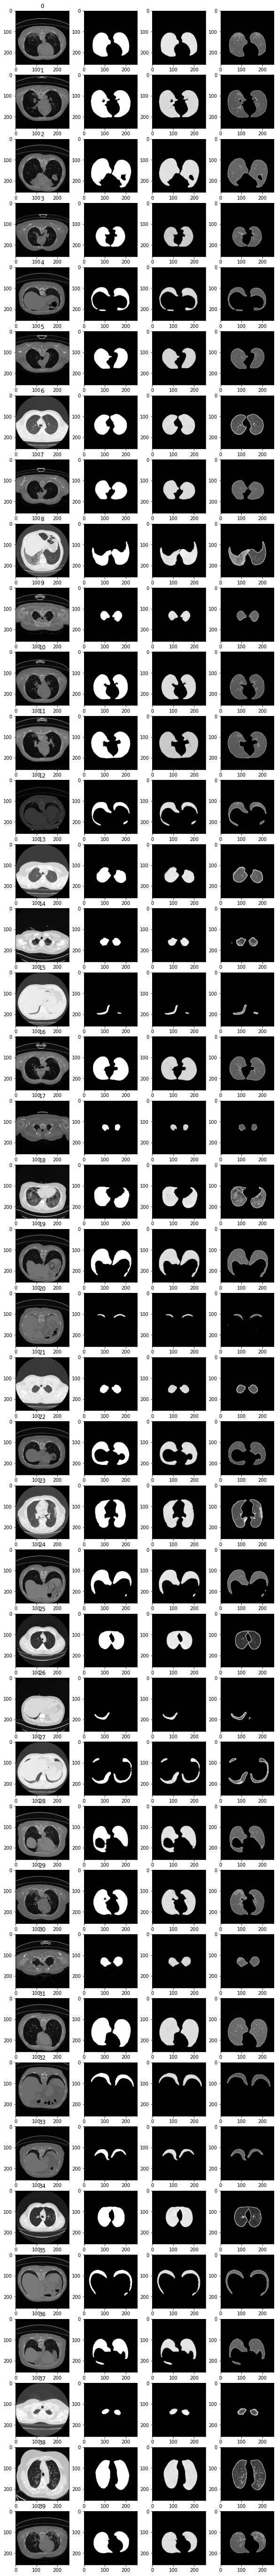

In [8]:
x_train, y_train, x_val, y_val = get_mask_data()
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

In [37]:
x_train_again, y_train_again, x_val_again, y_val_again = get_mask_data()

pre = model.predict(x_val_again)


def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

    

(2675, 256, 256, 1) (2675, 256, 256, 1)
(298, 256, 256, 1) (298, 256, 256, 1)


In [40]:
for i, pr in enumerate(pre) :
    pr = pr/ np.max(pr)
    y_val_again[i] = y_val_again[i] / np.max(y_val_again[i])


In [41]:
ground_truth_labels = y_val_again.ravel() # we want to make them into vectors
score_value = pre.ravel()

In [42]:
fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
roc_auc = auc(fpr,tpr)

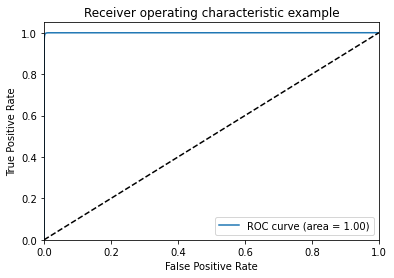

In [36]:
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

In [10]:
def get_predict_part(original ,predict) :
    copy_original = original.copy()
    
    for k, pred in enumerate(predict):
        pred_sum = pred[pred > 0]
        pred_mean = np.mean(pred_sum)
        if(np.min(copy_original[k]) >= 0) :
            copy_original[k][pred < pred_mean] = 0
        else :
            copy_original[k][pred < pred_mean] = -2048
            
    return copy_original

In [11]:
all_data_path= "transe"
original_data_path = "transe/data"
answer_data_path = "transe/transe"

data_set_folder_list = os.listdir(original_data_path)

for i, folder_name in enumerate(data_set_folder_list):
    address  = original_data_path + '/' + folder_name
    folder_video_set = os.listdir(address)
    for j, tar_name in enumerate(folder_video_set) :
        tar_address = address + '/' + tar_name
        raw_img = nib.load(tar_address)
        img_array = np.array(raw_img.get_fdata(), dtype=np.float32)
        images = img_array.T
        img_data = np.empty(( len(images), 256, 256, 1), dtype=np.float32)
        for i, image_array in enumerate(images) :
            img = resize(image_array, output_shape=(256, 256, 1), preserve_range=True)
            img_data[i] = img
        pres = model.predict(img_data)
        
        predict_lung = get_predict_part(img_data ,pres)
        
        
        
        save_address = answer_data_path + "/" + folder_name + "/" + tar_name
        np.save(save_address, predict_lung)



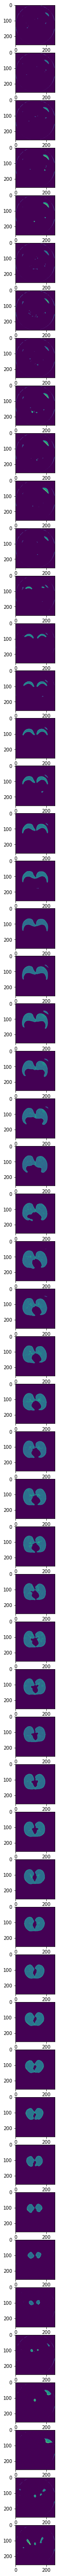

In [15]:
fff = 'transe/transe/CT-2/study_0939.nii.gz.npy'
sss=np.load(fff)

fig, ax = plt.subplots(54, 1, figsize=(10, 100))
    

for i in range(54):
    ax[i].imshow(sss[i].squeeze())
        

In [ ]:
# def get_predict_part(original ,predict) :
#     copy_original = original.copy()
    
#     for k, pred in enumerate(predict):
#         pred_sum = pred[pred > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(copy_original[k]) >= 0) :
#             copy_original[k][pred < pred_mean] = 0
#         else :
#             copy_original[k][pred < pred_mean] = -2048
            
#     return copy_original

In [ ]:
covid_path = "transe/COVID-19"
penumonia_path = "transe/non-COVID-19/CP"

covid_list = os.listdir(penumonia_path)
#penumonia_list = os.listdir(penumonia_path)
count = 0


for i, name in enumerate(covid_list) :
    address = penumonia_path + "/" + name
#     os.makedirs("transe/done_non-COVID-19/" + name)
    image_list = os.listdir(address)
    image_set = np.empty((len(image_list), 256, 256, 1), dtype = np.float32)
    for j, image_name in enumerate(image_list):
        image_path = os.path.join(address, image_name)
        img = Image.open(image_path)
        image_array = np.asarray(img)
        image = resize(image_array, output_shape=(256, 256, 1), preserve_range=True)
        image_set[j] = image
    predict = model.predict(image_set)
    
    for i, pred in enumerate(predict):
        pred_sum = pred[pred> 0]
        pred_mean = np.mean(pred_sum)
        if(np.min(image_set[i]) >= 0) :
            image_set[i][pred < pred_mean] = 0
        else :
            image_set[i][pred < pred_mean] = -2048

    
    predict_lung = get_predict_part(image_set ,predict)
    directory_path = "transe/done_non-COVID-19/" + name +"/"+ str(i)
#     fig, ax = plt.subplots(len(predict_lung), 2, figsize=(10, 100))
#     for i, lung in enumerate(predict_lung) :
#         ax[i,0].imshow(image_set[i].squeeze(), cmap='gray')
#         ax[i,1].imshow(lung.squeeze(), cmap='gray')
#     tem = input()
#     if(tem != 'y') : break
    np.save(directory_path, predict_lung)
    




In [ ]:
covid_path = "transe/done_COVID-19"

covid_list = os.listdir(covid_path)
#penumonia_list = os.listdir(penumonia_path)
count = 0

address = "transe/done_COVID-19/" + covid_list[3]
image_list = os.listdir(address)

image_path = os.path.join(address, image_list[0])
img_set = np.load(image_path)

fig, ax = plt.subplots(len(img_set), 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)
print(address)
for i, lung in enumerate(img_set) :
    ax[i].title.set_text(str(i))
    ax[i].imshow(lung.squeeze(), cmap='gray')